# Load the drive and the libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AN2DL_Challenge2/Final work

/content/drive/.shortcut-targets-by-id/1z8QzxNyqiMoMjU_ay1JaoBgH7ETjIkKq/AN2DL_Challenge2/Final work


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


## Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## EDA

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


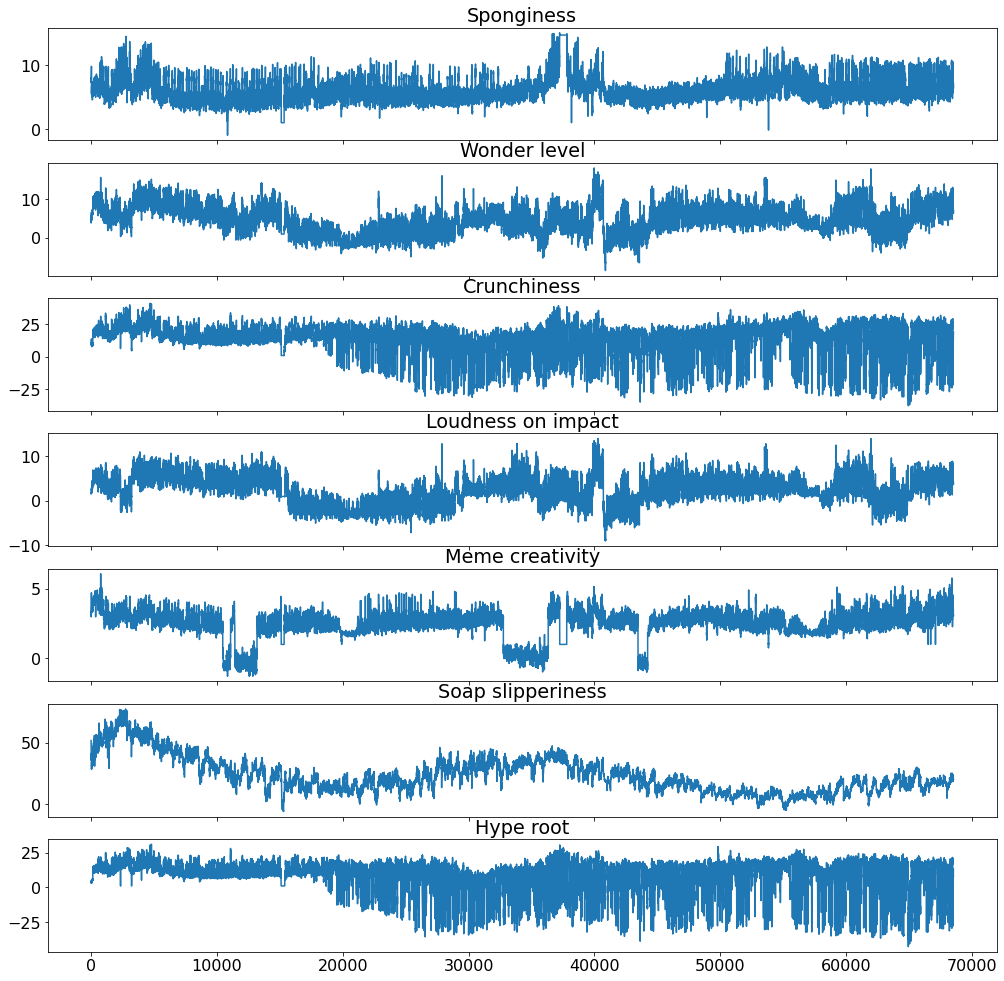

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(67528, 7) (1000, 7)


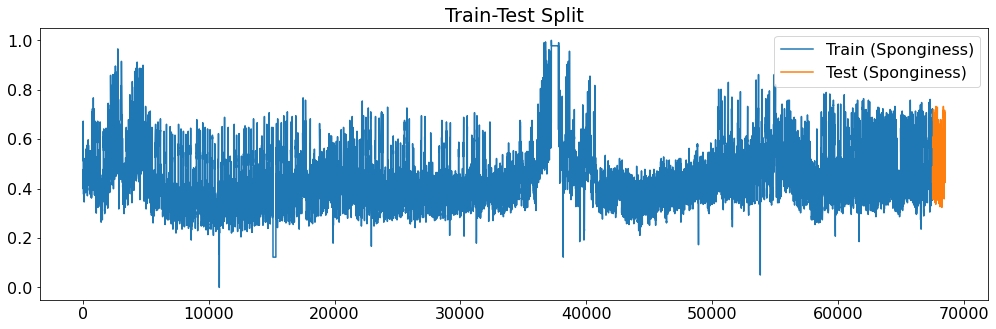

In [ ]:
test_size = 1000
X_train_raw = dataset.iloc[:-test_size]

X_test_raw = dataset.iloc[-test_size:]

print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
window = 300
stride = 15

In [ ]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 300, 7)

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

## Using LSTM

or using GRU instead of LSTM

In [ ]:
target_labels = dataset.columns
telescope = 100

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4494, 300, 7), (4494, 100, 7), (54, 300, 7), (54, 100, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

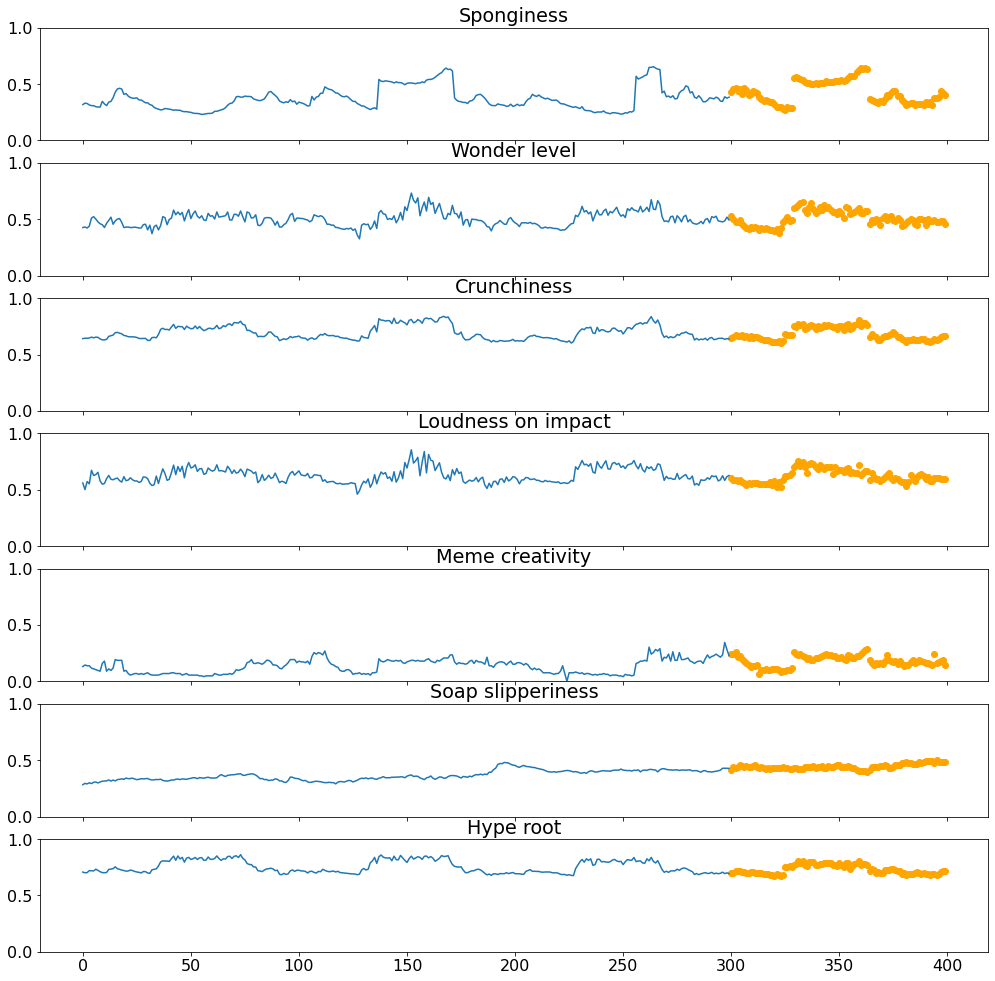

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_not_biLSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.LSTM(64, return_sequences=True)(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.LSTM(128, return_sequences=True)(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.LSTM(256, return_sequences=True)(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)

    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 300, 7)]          0         
                                                                 
 lstm_7 (LSTM)               (None, 300, 64)           18432     
                                                                 
 conv1d_10 (Conv1D)          (None, 300, 128)          24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 150, 128)          131584    
                                                                 
 conv1d_11 (Conv1D)          (None, 150, 256)          98560     
                                                             

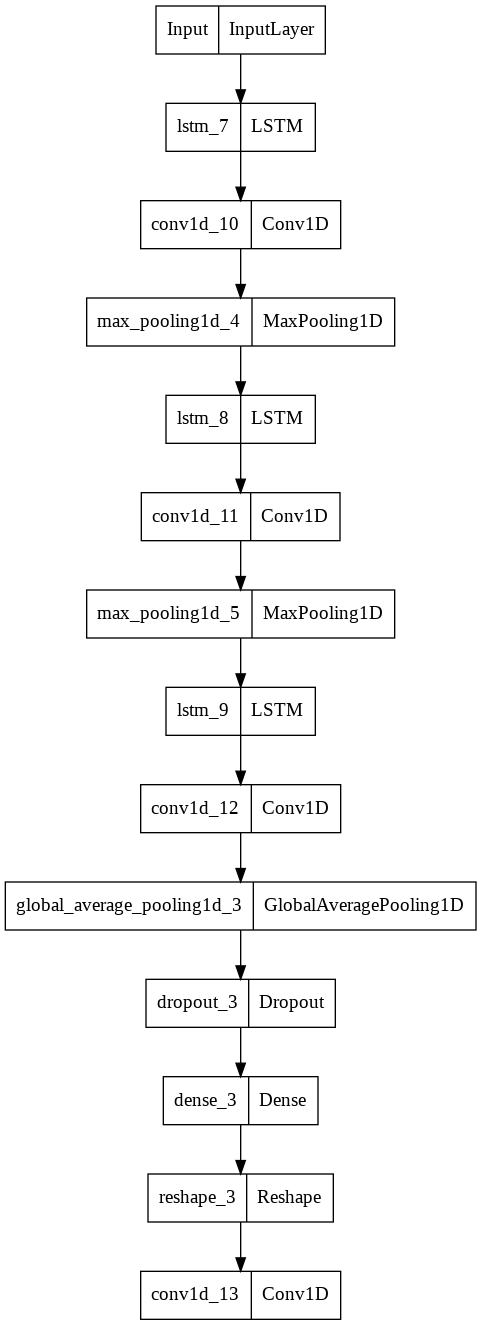

In [ ]:
model = build_CONV_not_biLSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
64/64 [==============================] - 8s 60ms/step - loss: 0.1413 - mae: 0.3164 - val_loss: 0.0682 - val_mae: 0.2181 - lr: 0.0010
Epoch 2/200
64/64 [==============================] - 3s 42ms/step - loss: 0.0361 - mae: 0.1499 - val_loss: 0.0236 - val_mae: 0.1159 - lr: 0.0010
Epoch 3/200
64/64 [==============================] - 3s 42ms/step - loss: 0.0203 - mae: 0.1108 - val_loss: 0.0218 - val_mae: 0.1129 - lr: 0.0010
Epoch 4/200
64/64 [==============================] - 3s 42ms/step - loss: 0.0185 - mae: 0.1052 - val_loss: 0.0210 - val_mae: 0.1080 - lr: 0.0010
Epoch 5/200
64/64 [==============================] - 3s 42ms/step - loss: 0.0180 - mae: 0.1036 - val_loss: 0.0213 - val_mae: 0.1078 - lr: 0.0010
Epoch 6/200
64/64 [==============================] - 3s 42ms/step - loss: 0.0179 - mae: 0.1032 - val_loss: 0.0213 - val_mae: 0.1062 - lr: 0.0010
Epoch 7/200
64/64 [==============================] - 3s 42ms/step - loss: 0.0176 - mae: 0.1021 - val_loss: 0.0225 - val_mae: 0.113

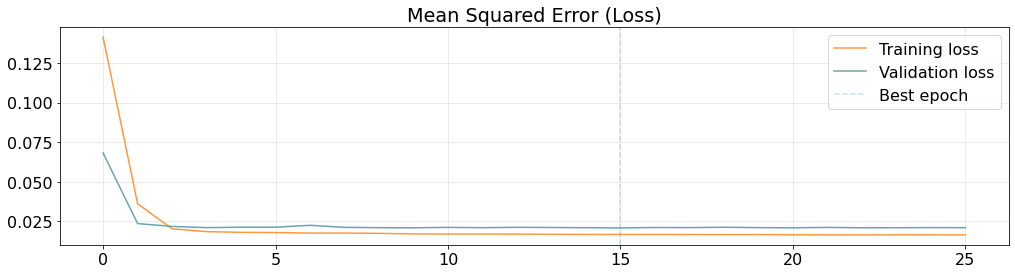

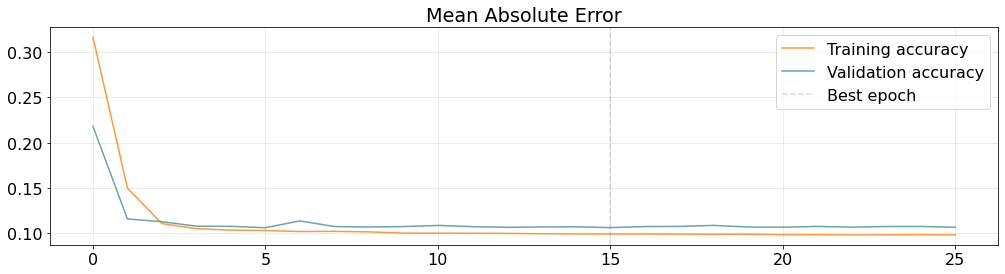

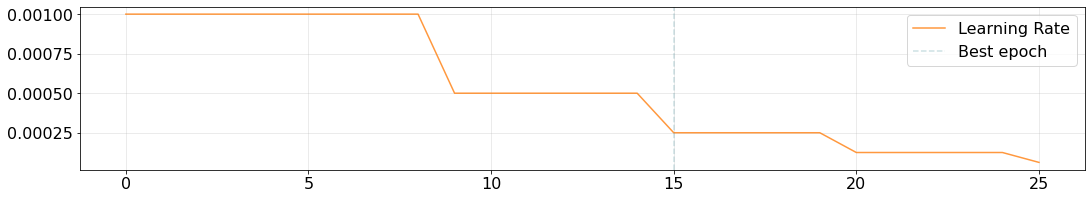

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# First Model : Direct Forecasting

In [ ]:
target_labels = dataset.columns
telescope = 100

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4494, 300, 7), (4494, 100, 7), (54, 300, 7), (54, 100, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

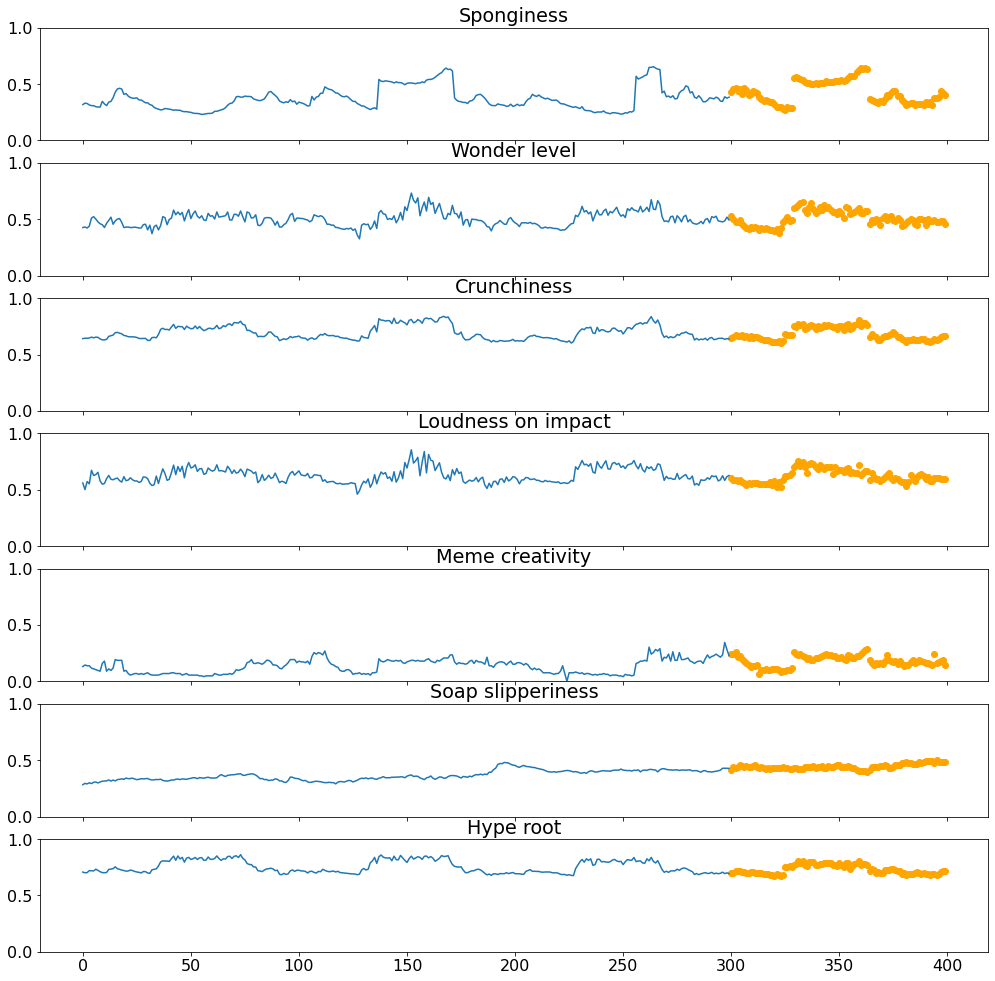

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)

    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 300, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         36864     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 256)         263168    
 nal)                                                            
                                                             

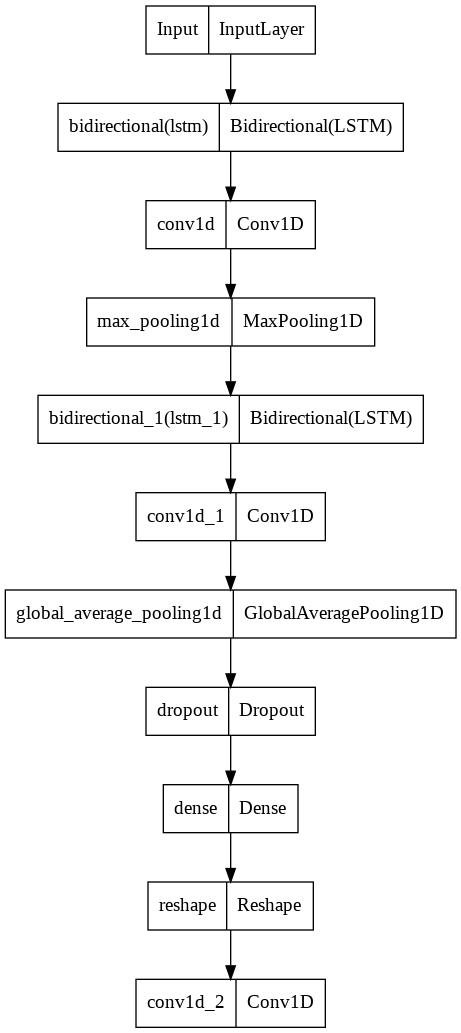

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
64/64 [==============================] - 94s 1s/step - loss: 0.0840 - mae: 0.2244 - val_loss: 0.0291 - val_mae: 0.1351 - lr: 0.0010
Epoch 2/200
64/64 [==============================] - 85s 1s/step - loss: 0.0244 - mae: 0.1212 - val_loss: 0.0215 - val_mae: 0.1110 - lr: 0.0010
Epoch 3/200
64/64 [==============================] - 85s 1s/step - loss: 0.0198 - mae: 0.1083 - val_loss: 0.0203 - val_mae: 0.1091 - lr: 0.0010
Epoch 4/200
64/64 [==============================] - 86s 1s/step - loss: 0.0179 - mae: 0.1027 - val_loss: 0.0189 - val_mae: 0.1014 - lr: 0.0010
Epoch 5/200
64/64 [==============================] - 85s 1s/step - loss: 0.0171 - mae: 0.1001 - val_loss: 0.0193 - val_mae: 0.1029 - lr: 0.0010
Epoch 6/200
64/64 [==============================] - 84s 1s/step - loss: 0.0164 - mae: 0.0977 - val_loss: 0.0188 - val_mae: 0.1012 - lr: 0.0010
Epoch 7/200
64/64 [==============================] - 85s 1s/step - loss: 0.0158 - mae: 0.0956 - val_loss: 0.0189 - val_mae: 0.1002 - lr:

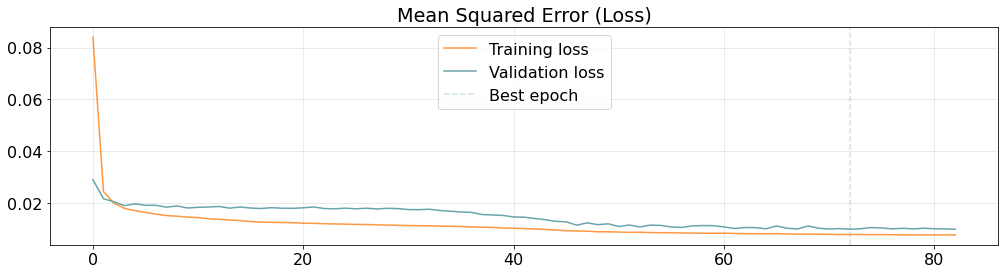

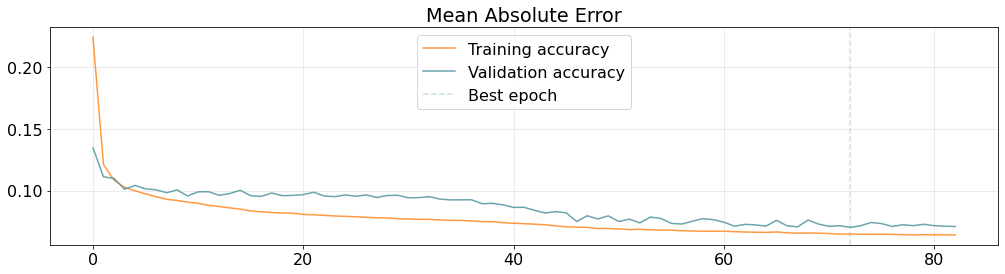

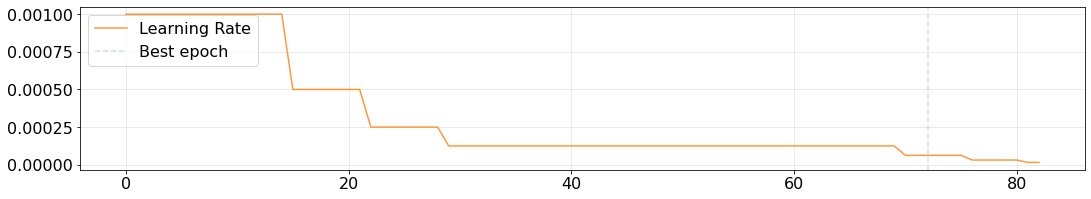

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# model.save('DirectForecasting')
model = tfk.models.load_model('DirectForecasting')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(54, 100, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.007265181>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.059142936>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

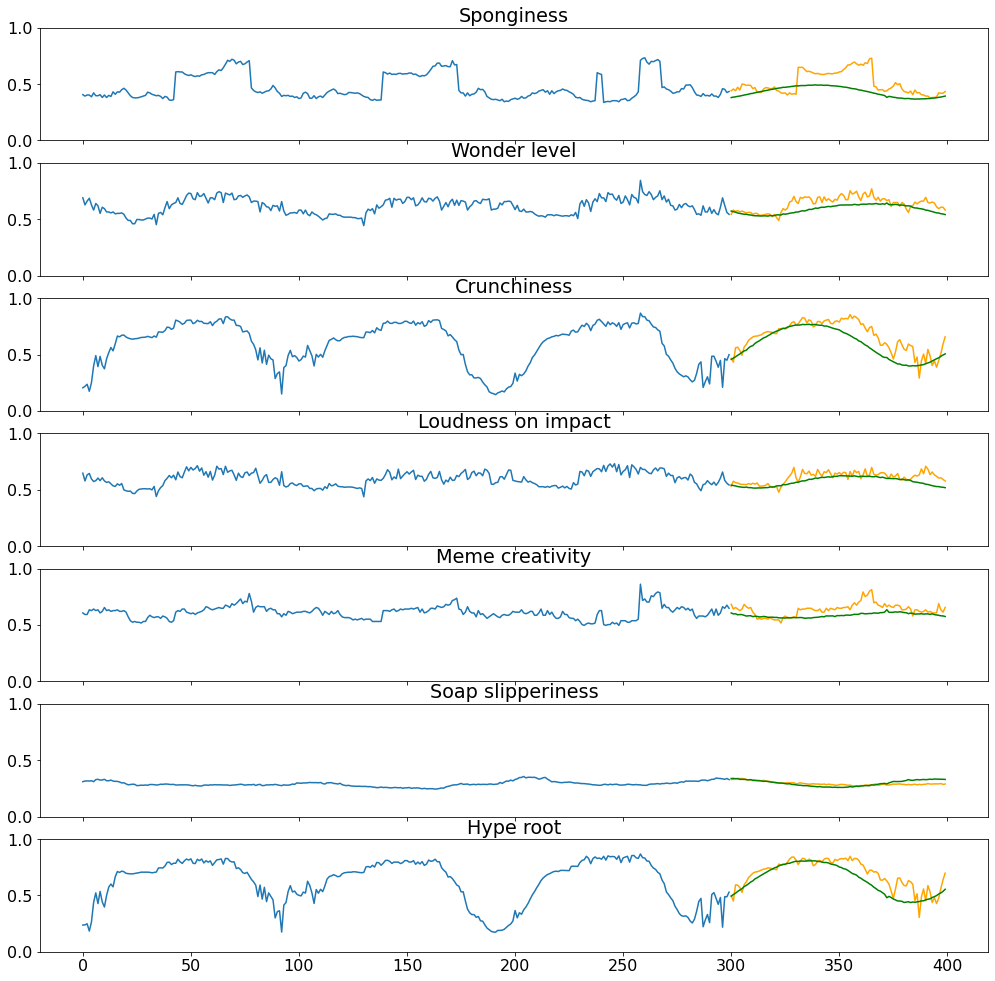

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

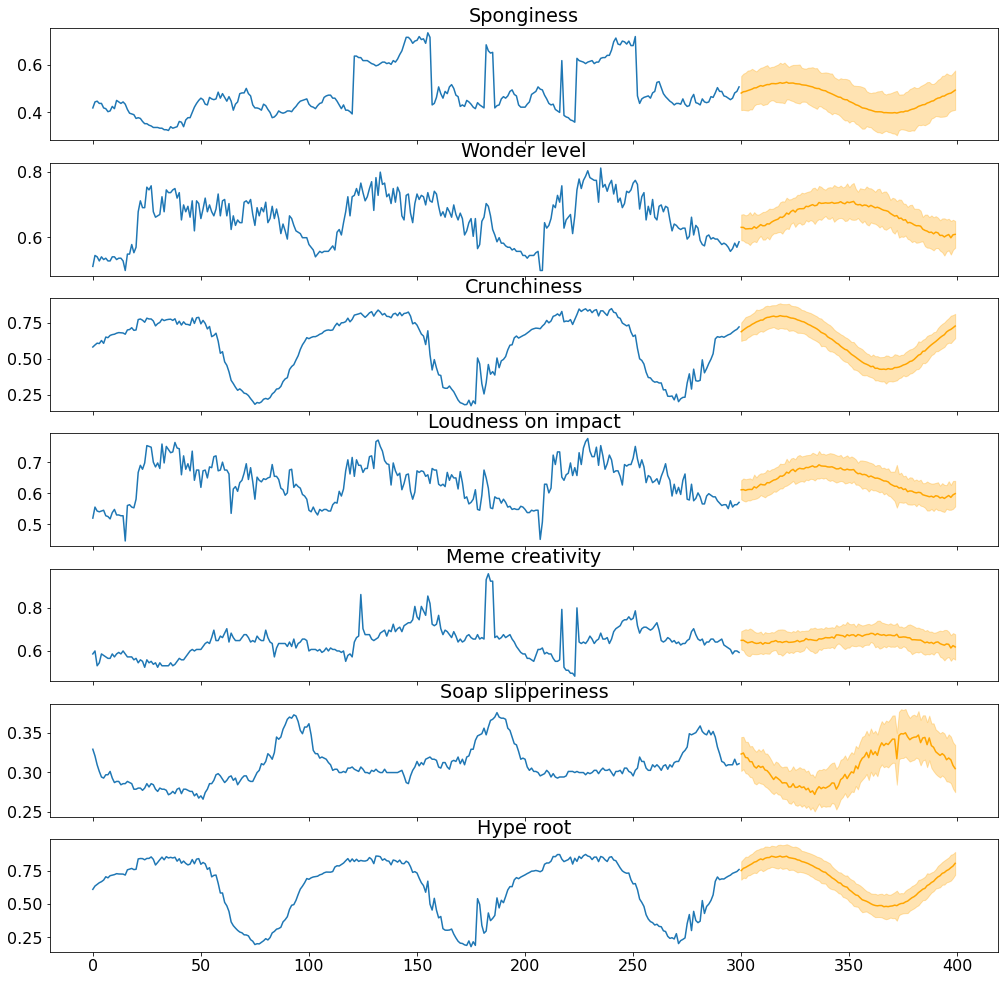

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    
plt.show()

# Second Model : Autoregressive model

In [ ]:
target_labels = dataset.columns
telescope = 1

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4500, 300, 7), (4500, 1, 7), (60, 300, 7), (60, 1, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

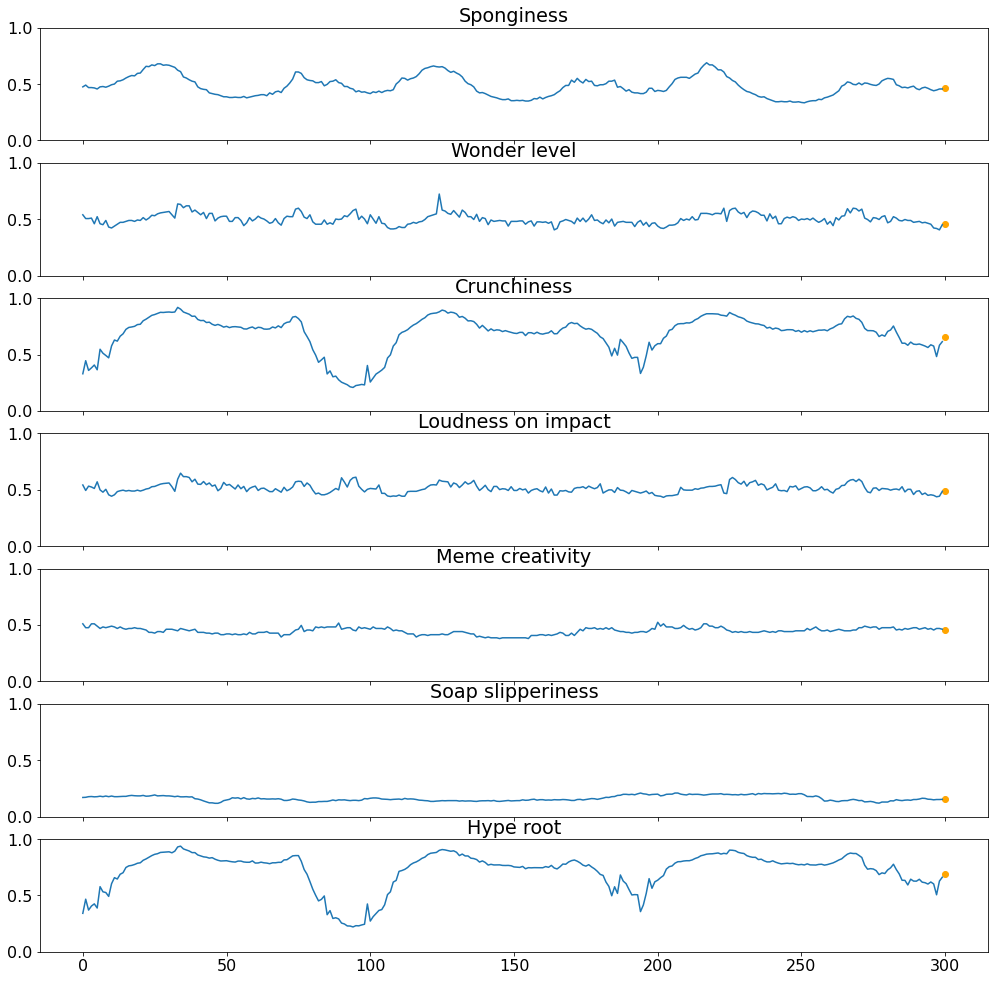

In [ ]:
inspect_multivariate(X_train, y_train,target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)

    convlstm = tfkl.MaxPool1D()(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)

    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 300, 7)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 300, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 150, 256)         263168    
 nal)                                                            
                                                             

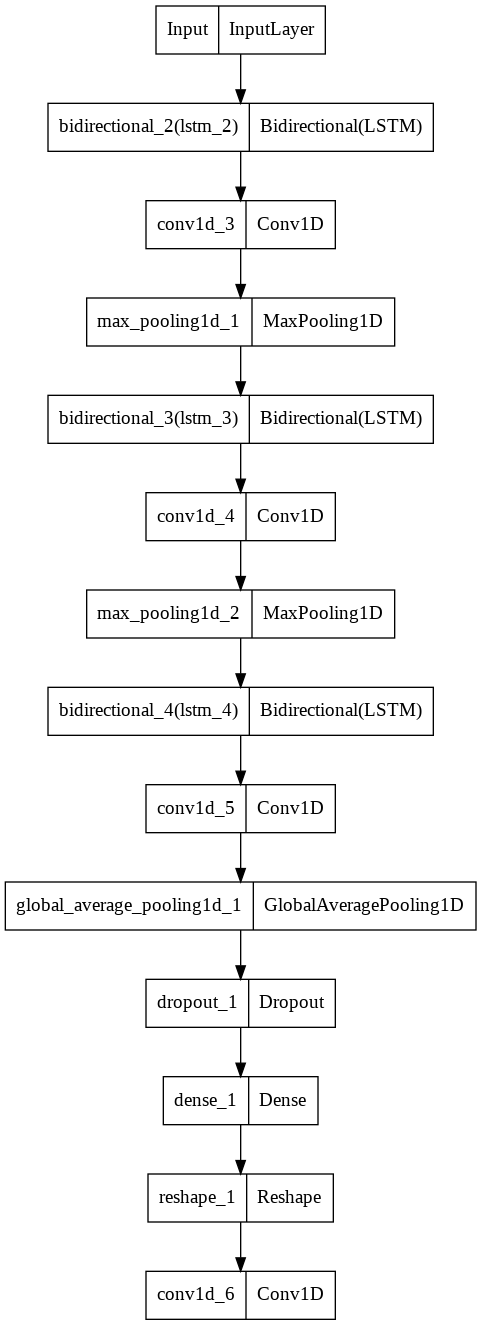

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
57/57 [==============================] - 15s 117ms/step - loss: 0.1206 - mae: 0.2893 - val_loss: 0.0578 - val_mae: 0.2064 - lr: 0.0010
Epoch 2/200
57/57 [==============================] - 5s 80ms/step - loss: 0.0300 - mae: 0.1397 - val_loss: 0.0227 - val_mae: 0.1221 - lr: 0.0010
Epoch 3/200
57/57 [==============================] - 5s 79ms/step - loss: 0.0194 - mae: 0.1083 - val_loss: 0.0185 - val_mae: 0.1041 - lr: 0.0010
Epoch 4/200
57/57 [==============================] - 5s 79ms/step - loss: 0.0179 - mae: 0.1037 - val_loss: 0.0165 - val_mae: 0.0972 - lr: 0.0010
Epoch 5/200
57/57 [==============================] - 4s 79ms/step - loss: 0.0164 - mae: 0.0991 - val_loss: 0.0165 - val_mae: 0.0967 - lr: 0.0010
Epoch 6/200
57/57 [==============================] - 4s 79ms/step - loss: 0.0157 - mae: 0.0961 - val_loss: 0.0147 - val_mae: 0.0871 - lr: 0.0010
Epoch 7/200
57/57 [==============================] - 5s 79ms/step - loss: 0.0148 - mae: 0.0932 - val_loss: 0.0165 - val_mae: 0.0

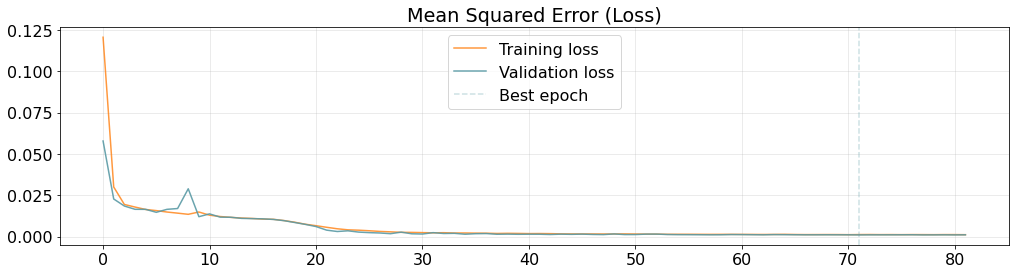

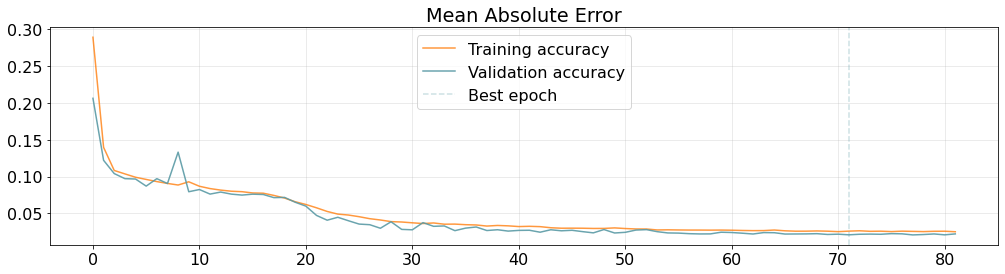

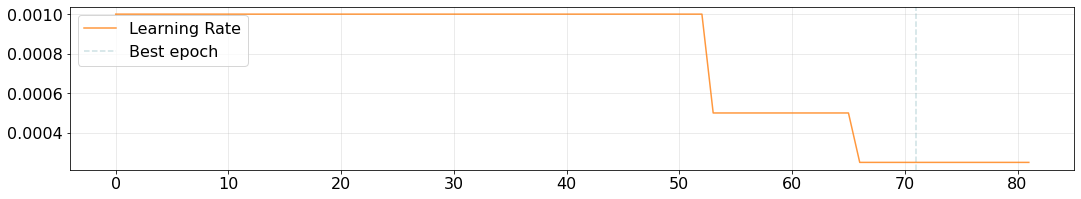

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('AuroregressiveForecasting')

In [ ]:
model = tfk.models.load_model('AuroregressiveForecasting')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(60, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0010163462>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.021091202>)

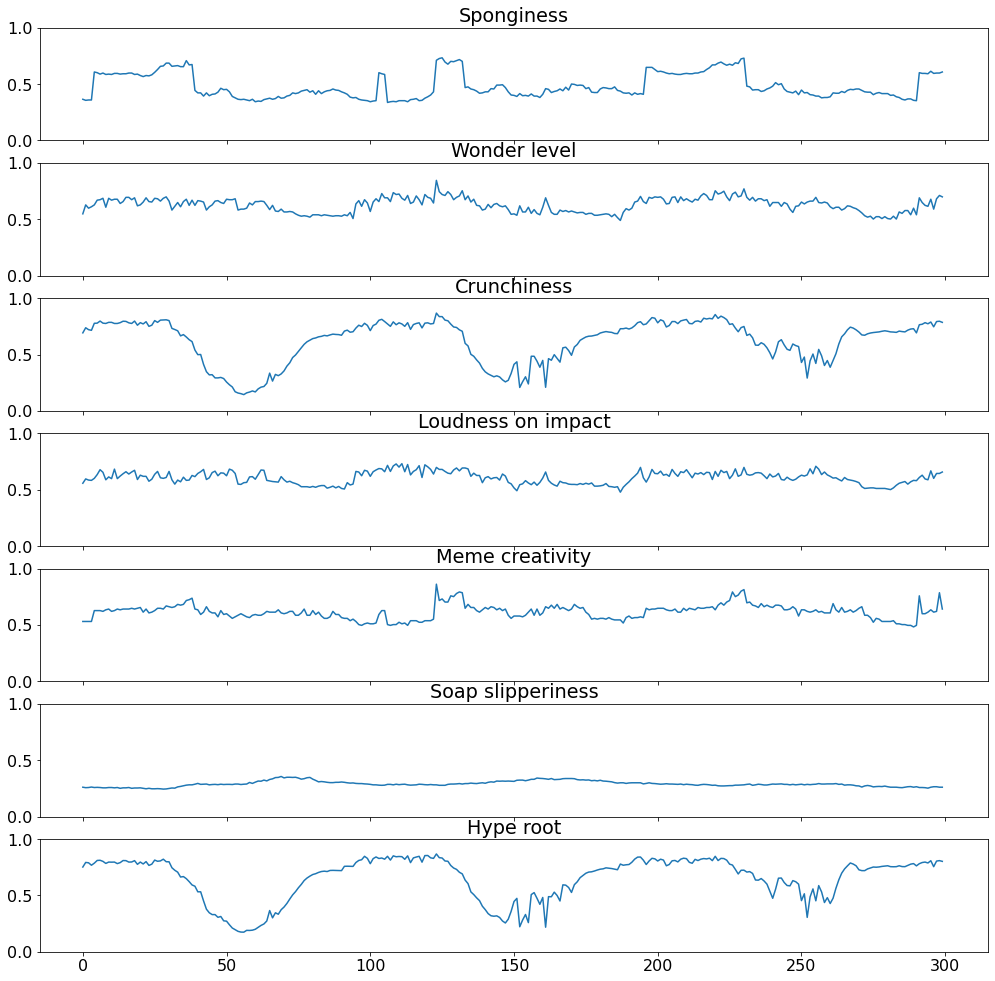

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
reg_telescope = 100
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((54, 300, 7), (54, 100, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.009867672>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.070093185>)

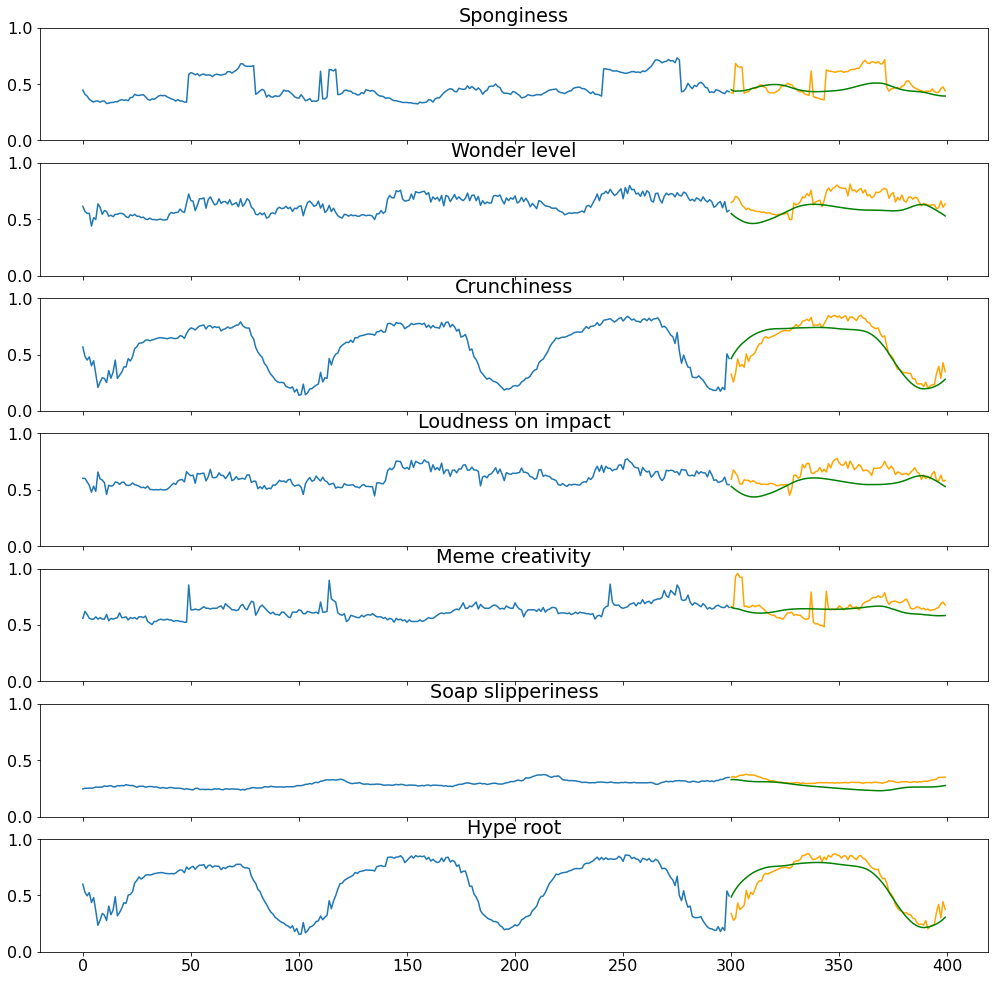

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

In [ ]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
# Autoregressive Forecasting (Future)
reg_future = np.array([])
X_temp = future # The sequence to forecast
for reg in range(0,reg_telescope,telescope): # For each telescope step (i.e., reg_telescope%telescope is preferred to be 0)
    pred_temp = model.predict(X_temp) # Predict the current sequence
    if(len(reg_future)==0):
        reg_future = pred_temp # Initialize the forecasting
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1) # Append the prediction to the whole forecasting
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1) # Shift the input of the next predict so that the just predicted sequence is at the end of the input, and the dimension is correct

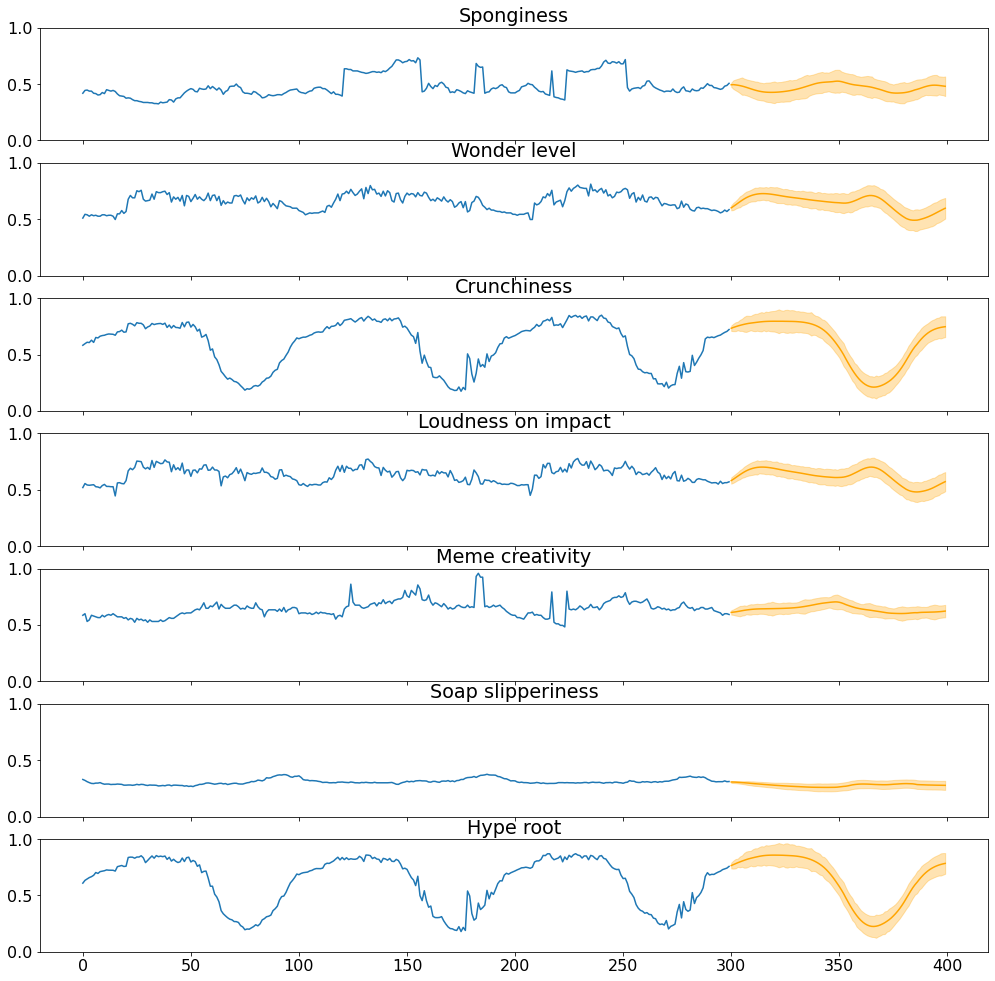

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()